## Исследование тенденций игрового рынка

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников мы получили исторические данные о продажах игр, оценке пользователей и экспертов, жанрах и игровых платформах. 

**Цель проекта:**

Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на предстоящий 2017-й год.

**План проекта:**

**Шаг 1.** Изучение общей информации

**Шаг 2.** Подготовка данных. Преобразование данные в корректные и обработка пропусков

**Шаг 3.** Анализ данных

**Шаг 4.** Составление портрета пользователя и его предпочтений

**Шаг 5.** Проверка гипотез

**Шаг 6.** Общий вывод

**Данные из файла games.csv:**

- ```Name``` — название игры
- ```Platform``` — платформа
- ```Year_of_Release``` — год выпуска
- ```Genre``` — жанр игры
- ```NA_sales``` — продажи в Северной Америке (миллионы проданных копий)
- ```EU_sales``` — продажи в Европе (миллионы проданных копий)
- ```JP_sales``` — продажи в Японии (миллионы проданных копий)
- ```Other_sales``` — продажи в других странах (миллионы проданных копий)
- ```Critic_Score``` — оценка критиков (максимум 100)
- ```User_Score``` — оценка пользователей (максимум 10)
- ```Rating``` — рейтинг от организации ESRB

_____
_____

Первым делом импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

Вторым делом соберём все функции и разные технические моменты в один класс. Так код ниже будет выглядеть аккуратнее, а в класс собираем просто потому, что это удобно и ко всем методам при обращении к ним будет всплывать подсказка:

In [2]:
class RequestStatistics():

    
    def __init__(self, feature=None, feature2=None, df=None):
        self.feature = feature
        self.feature2 = feature2
        self.df = df
        
        
    def description(self):
        '''
        метод возвращает одной строкой параметры данные, такие как:
        :return: mean, median, std, sum, min, max
        '''
        print(f'{self.feature.name}:'
              f'\nсреднее = {self.feature.mean():.4f}, '
              f'медиана = {self.feature.median():.2f}, '
              f'ср.отклонение = {self.feature.std():.2f}, '
              f'сумма = {self.feature.sum():.2f}, '
              f'min = {self.feature.min():.2f}, '
              f'max = {self.feature.max():.2f}')
        
        
    def get_hist(self, name, median=False, mode=False, mean=False):
        '''
        метод строит гистрограмму по переданному признаку
        :param name: название графика, median, mode, mean: опционально
        :return: plt.hist()
        '''
        sns.set(style='ticks', palette='pastel')
        plt.figure(figsize=(11, 3))
        sns.histplot(data=self.feature, x=self.feature, kde=True, 
                     color='#7DCEA0', edgecolor='#27AE60', label=self.feature.name)
        if median:
            median = self.feature.median()
            plt.axvline(x=median, label=f'медиана={int(median)}', lw=1.5, c='#E832F7')
        if mode:
            mode = self.feature.mode().values[0]
            plt.axvline(x=mode, label=f'мода={np.round(mode)}', lw=1.5, c='#F74732')
        if mean:
            mean = self.feature.mean()
            plt.axvline(x=mean, label=f'среднее={int(mean)}', lw=1.5, c='#326BF7')
        plt.legend()
        plt.xlabel(name)
        plt.ylabel('количество')
        plt.title(name, fontweight='bold')
        plt.xticks(rotation=25)
        plt.grid(linestyle=':');
        
    
    def get_violin(self, name):
        '''
        метод строит violinplot
        :param name: название графика
        :return: sns.violinplot()
        '''
        sns.set(style='ticks', palette='pastel')
        plt.figure(figsize=(11, 3))
        sns.violinplot(data=self.feature, x=self.feature, color='#A9DFBF')
        plt.xlabel(name)
        plt.ylabel('количество')
        plt.title(name, fontweight='bold')
        plt.grid(linestyle=':');
        
        
    def get_regplot(self, f=None):
        '''
        метод строит regplot
        :param f: список с названием графика и его осей
        :return: sns.regplot()
        '''
        if f:
            name1, name2, xlabel = f[0], f[1], f[2]
        else:
            name1, name2 = self.feature.name, self.feature2.name
        sns.set(style='ticks', palette='pastel')
        plt.figure(figsize=(11, 4))
        sns.regplot(x=self.feature2, y=self.feature, 
                    scatter_kws={'s': 20, 'color': '#00CDF6', 'edgecolors': '#005DF6'}, 
                    line_kws={'color': '#B300F6'})
        plt.title(f'влияние {name2} на {name1}\n'
                  f'корр. Пирсона = {np.corrcoef(self.feature2, self.feature)[0,1]:.4f}', 
                  fontweight='bold')
        plt.xlabel(xlabel)
        plt.ylabel('продажи')
        plt.grid(linestyle=':');
        
        
    def get_regplot_many_charts(self, count_list, f, t):
        '''
        метод строит несколько regplot в объекте фигуры в формате 3x3
        :param count_list: список заголовков f: feature - название признака t: общий заголовок
        :return: sns.regplot()
        '''
        sns.set(style='ticks', palette='pastel')
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
        fig.suptitle(t, fontsize=16, fontweight='bold')
        for i, platform in enumerate(count_list):
            row = i // 3
            col = i % 3
            df_ = self.df.loc[self.df[f] == platform]
            sns.regplot(x=df_[self.feature2.name].name, y=df_[self.feature.name].name, 
                        data=df_, ax=ax[row][col],
                        scatter_kws={'s': 20, 'color': '#00CDF6', 'edgecolors': '#005DF6'},
                        line_kws={'color': '#B300F6'})
            ax[row][col].set_title(f'{platform}, '
                                   f'corr = {np.corrcoef(df_[self.feature2.name], df_[self.feature.name])[0,1]:.2f}')
            ax[row][col].set_xlabel('')
            ax[row][col].set_ylabel('продажи')
            ax[row][col].grid(linestyle=':')
        plt.tight_layout()
        
       
    def get_ttest_ind(self, alpha=0.05, equal_var=False):
        '''
         метод для проведения двухвыборочного t-теста на независимых выборках
         :param alpha, equal_var: опционально
         :return: st.ttest_ind()
        '''
        results = st.ttest_ind(self.feature, self.feature2, equal_var=equal_var, nan_policy='omit')
        print(f'pvalue = {results.pvalue:.4f}')
        print('отвергаем H0') if results.pvalue < alpha else print('принимаем H0')
        
        
    @staticmethod
    def get_barh(question, name):  
        '''
        метод строит barh
        :param question: данные, get_barh: подпись для оси OX
        :return plt.barh()
        '''
        sns.set(style='whitegrid', palette='Set2')
        plt.figure(figsize=(11, 5))
        plt.barh(question.index, question['median'], color='#E8DAEF', edgecolor='#A569BD')
        plt.xlabel('медиана')
        plt.ylabel(name)
        plt.title(f'Медиана продаж по {question.index.name}', fontweight='bold');


    @staticmethod
    def get_pie(*args, t=False, t_list=None):
        '''
        метод строит несколько pie в объекте фигуры в формате 2x2
        :param *args: данные, t, t_list: опционально (заголовки)
        :return: plt.pie() 
        '''
        sns.set(style='whitegrid', palette='Set2')
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        if t:
            fig.suptitle(t, fontsize=16, fontweight='bold')
        ax = ax.flatten()
        for i, p in enumerate(args):
            ax[i].pie(p, labels=p.index, autopct='%1.1f%%', textprops={'fontsize': 8}, pctdistance=0.8)
            ax[i].set_title(f'{t_list[i]}', fontweight='bold')
            ax[i].axis('equal')

        
    @staticmethod
    def get_plot(df, quantity):
        '''
        метод строит несколько линий plot() в одной фигуре
        :param quantity: отсечка для данных (с какого порога начинать)
        :return: plt.plot()
        '''
        sns.set(style='ticks', palette='muted')
        plt.figure(figsize=(12, 6))

        for i in df.platform.unique():
            spam = df.loc[df['platform'] == i, 
                          ['year_of_release', 'total_sale']].groupby('year_of_release')['total_sale'].sum()
            if spam[spam > quantity].shape[0] > 1:
                plt.plot(spam[spam>5], label=f'{i}')
        plt.xticks(np.sort(df.year_of_release.unique()), rotation=90)
        plt.legend()
        plt.grid(linestyle=':');
        
        
    @staticmethod
    def get_boxplot(df, best_platforms):
        '''
        метод строит boxplot
        :param best_platforms: список названий из признака platform
        :return: sns.boxplot()
        '''
        sns.set(style='whitegrid', palette='Set2')
        q = df.query('platform in @best_platforms')
        plt.figure(figsize=(12, 5))
        sns.boxplot(x=q.platform, y=df.total_sale)
        plt.yscale('log')
        plt.title('популярные платформы', fontweight='bold')
        plt.grid(linestyle=':');

        
    @staticmethod
    def get_lineplot(df, pivot_descr):
        '''
        метод строит несколько линий в объекте фигуры в двух plot-графиках формата 2x1 
        :param pivot_descr: данные
        :return: plt.plot()
        '''
        sns.set(style='ticks', palette='muted')
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
        ax1, ax2 = ax.flatten()

        for i in df.platform.unique():
            ax1.plot(pivot_descr['count'][i], label=f'{i}')
        for i in df.platform.unique():
            ax2.plot(pivot_descr['sum'][i], label=f'{i}')
        ax1.legend(loc=3)
        ax1.set_title('количество проданных копий', fontweight='bold')
        ax1.grid(linestyle=':')
        ax2.legend(loc=3)
        ax2.set_title('сумма', fontweight='bold')
        ax2.grid(linestyle=':');

_____
_____

### Шаг 1. Откроем файл с данными и изучим общую информацию

In [3]:
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('https://____')

Вот данные, смотрим, знакомимся:

In [4]:
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.tail(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


In [6]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.48,5.88,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.26,0.81,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.15,0.50,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.08,0.31,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.05,0.19,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.97,13.94,13.0,60.0,71.00,79.00,98.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [8]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Посмотрим, какие признаки у нас есть и что по ним видно: 

- **```Name``` — *название игры*** - тип object и есть 2 пропуска
- **```Platform``` — *платформа*** - тип object без пропусков
- **```Year_of_Release``` — *год выпуска*** зачем-то float64 и с пропусками
- **```Genre``` — *жанр игры*** - тип object и есть 2 пропуска, интересно, не те же это пропуски, что и у ```Name```?
- **```NA_sales``` — *продажи в Северной Америке (миллионы проданных копий)*** - тип float64 и без пропусков
- **```EU_sales``` — *продажи в Европе (миллионы проданных копий)*** - тип float64 и без пропусков
- **```JP_sales``` — *продажи в Японии (миллионы проданных копий)*** - тип float64 и без пропусков
- **```Other_sales``` — *продажи в других странах (миллионы проданных копий)*** - тип float64 и без пропусков
- **```Critic_Score``` — *оценка критиков (максимум 100)*** - тип float64 и много пропусков, почему?
- **```User_Score``` — *оценка пользователей (максимум 10)*** - как и у ```Critic_Score``` тип float64 и много пропусков
- **```Rating``` — *рейтинг от организации ESRB*** - тип object и много пропусков, разберёмся

**Предварительный вывод**. На данном этапе мы:

- загрузили датасет
- посмотрели на первые и последние строчки, всего записей у нас 16715
- посмотрели на признаки, их 11, далее будем изучать их детальнее, но уже сейчас можно поставить себе некоторые задачи, такие как:
    - ```Name```, ```Year_of_Release```, ```Genre```, ```Critic_Score```, ```User_Score```, ```Rating``` - нужно будет обрабатать пропуски
    - ```Year_of_Release``` - исправить тип данных на корректный

_____
_____

### Шаг 2. Подготовим данные. Преобразуем данные в корректные типы там, где это необходимо и обработаем пропуски там, где это возможно

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Заменим названия столбцов, переведём их в snake_case:

In [10]:
[df.rename(columns={i: i.lower()}, inplace=True) for i in df.columns]
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Приведём ещё все строковые значения в таблице к нижнему регистру и удалим в них возможные лишние пробелы между словами. Порядок в таблице в дальнейшем нам может пригодиться:

In [11]:
for i in ['name', 'genre', 'platform', 'rating']:
    df[i] = df[i].str.lower().str.strip()

**```name``` и ```genre```**

Посмотрим на пропуски в ```name``` и ```genre```, их там всего по 2 шт.:

In [12]:
df.query('name.isna() and genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как и предполагали, пропуски в ```name``` и ```genre``` относятся к одним и тем же строкам. Названия нет, игровой платформы нет, год 1993-й уж очень древний $\Rightarrow$ снесём их:

In [13]:
df.dropna(subset=['name', 'genre'], inplace=True)

**```year_of_release```**

Хочется поменять тип данных у года релиза, а то что это такое, год и float, но у нас там 269 пропусков, так что для начала посмотим на этот признак:

In [14]:
df[df['year_of_release'].isna()].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,NaN,sports,4.26,0.26,0.01,0.71,94.0,8.5,e
377,fifa soccer 2004,ps2,NaN,sports,0.59,2.36,0.04,0.51,84.0,6.4,e
456,lego batman: the videogame,wii,NaN,action,1.80,0.97,0.00,0.29,74.0,7.9,e10+
475,wwe smackdown vs. raw 2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,rock band,x360,NaN,misc,1.93,0.33,0.00,0.21,92.0,8.2,t
657,frogger's adventures: temple of the frog,gba,NaN,adventure,2.15,0.18,0.00,0.07,73.0,tbd,e
678,lego indiana jones: the original adventures,wii,NaN,action,1.51,0.61,0.00,0.21,78.0,6.6,e10+
719,call of duty 3,wii,NaN,shooter,1.17,0.84,0.00,0.23,69.0,6.7,t
805,rock band,wii,NaN,misc,1.33,0.56,0.00,0.20,80.0,6.3,t


Ничего не понятно, но очень интересно. При беглом просмотре не видно никакой логики в пропусках даты. Возможно, место имел какой-то технический сбой, а может год был необязательным для заполнения значением или игры бкз года настолько старые, что никто уже и не помнит, когда они появились. Игры без года могут помешать дальнейшему исследованию, с ними точно нужно будет что-то сделать. Посмотрим, к каким приставкам они относятся:

In [15]:
df[df['year_of_release'].isna()].groupby('platform')['platform'].count()

platform
2600    17
3ds      8
ds      30
gb       1
gba     11
gc      14
n64      3
pc      17
ps       7
ps2     34
ps3     25
psp     16
psv      1
wii     34
x360    30
xb      21
Name: platform, dtype: int64

- ```Atari 2600``` - 1977 год
- ```Nintendo 3DS``` - 2011 год
- ```Nintendo DS``` - 2004 год 
- ```Game Boy``` - 1990 год
- ```Game Boy Advance``` - 2001 год
- ```Nintendo GameCube``` - 2001 год
- ```Nintendo 64``` - 1996 год
- ```ПК``` - вне времени, вечно :)
- ```PlayStation``` - 1994 год
- ```PlayStation 2``` - 2000 год
- ```PlayStation 3``` - 2006 год
- ```PlayStation``` Portable - 2004 год
- ```PlayStation Vita``` - 2011 год
- ```Nintendo Wii``` - 2006 год
- ```Xbox 360``` - 2005 год
- ```Xbox``` - 2002 год

Годы выпуска &uarr;&uarr;&uarr; игровых консолей, для некоторых игр которых не проставлена дата, узнали, Самая свежая из них ```PlayStation 3``` и ```PlayStation Vita```. 

Год выпуска приставки совсем не означает, что игры к ней такие же древние и бородатые)) в целом ничего такого, что могло бы помочь с разработкой бизнес-стратегии на 2017-й год, мы не должны потерять. Проверим, сколько мы потеряем информации при удалении этих строк (а заодно заведём себе переменную с изначальным размером датафрейма. Будем с ней сверяться при удалениях строк, чтоб контролировать себя и не перемахнуть лишнего):

In [16]:
size_at_start = df.shape[0]
f"{df[df['year_of_release'].isna()].shape[0] / size_at_start:.2%}"

'1.61%'

Потеряем 1.6% старых игр, не криминально. Удалим:

In [17]:
df.dropna(subset=['year_of_release'], inplace=True)

Проверим теперь, нет ли явных дубликатов:

In [18]:
print('дубликаты есть') if sum(df.duplicated()) else print('дубликатов нет')

дубликатов нет


А неявные?

In [19]:
df.loc[df[['name', 'platform']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,need for speed: most wanted,x360,2005.0,racing,1.0,0.13,0.02,0.10,83.0,8.5,t
11715,need for speed: most wanted,pc,2012.0,racing,0.0,0.06,0.00,0.02,82.0,8.5,t
16230,madden nfl 13,ps3,2012.0,sports,0.0,0.01,0.00,0.00,83.0,5.5,e


Что-то нашли! Изучим каждую игру по отдельности:

```need for speed: most wanted``` - здесь переиздание в разные года для разных платформ, такое бывает. Это не дубль. Зато уточнили рейтинг NFS для PS3 - он [тоже T](https://ru.wikipedia.org/wiki/Need_for_Speed:_Most_Wanted_(2012)#:~:text=%E2%80%94%20%C2%AB%D0%96%D0%B0%D0%B6%D0%B4%D0%B0%20%D1%81%D0%BA%D0%BE%D1%80%D0%BE%D1%81%D1%82%D0%B8%3A%20%D0%A1%D0%B0%D0%BC%D1%8B%D0%B9%20%D1%80%D0%B0%D0%B7%D1%8B%D1%81%D0%BA%D0%B8%D0%B2%D0%B0%D0%B5%D0%BC%D1%8B%D0%B9,%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20%D1%83%D1%81%D1%82%D1%80%D0%BE%D0%B9%D1%81%D1%82%D0%B2%20%D0%B2%202012%20%D0%B3%D0%BE%D0%B4%D1%83.), заполним пропуск:

In [20]:
df.loc[(df['name'] == 'need for speed: most wanted')&((df['platform'] == 'x360')|(df['platform'] == 'ps3'))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
523,need for speed: most wanted,ps3,2012.0,racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,need for speed: most wanted,x360,2012.0,racing,0.62,0.78,0.01,0.15,83.0,8.5,t
1591,need for speed: most wanted,x360,2005.0,racing,1.00,0.13,0.02,0.10,83.0,8.5,t


In [21]:
df.loc[523, 'rating'] = 't'

```madden nfl 13``` - а вот это явно дубликат неявный! Удалим:

In [22]:
df.loc[(df['name'] == 'madden nfl 13')&(df['platform'] == 'ps3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012.0,sports,2.11,0.22,0.0,0.23,83.0,5.5,e
16230,madden nfl 13,ps3,2012.0,sports,0.00,0.01,0.0,0.00,83.0,5.5,e


In [23]:
df.drop(index=16230, inplace=True)

Итого: явных дубликатов не нашли, неявный один, игры без года снесли, теперь можно формат даты менять, сделаем это с помощью *pd.to_numeric* с аргументом *downcast='integer'* для использования наименьшего возможного размера хранения чисел:

In [24]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], downcast='integer') 

**```critic_score```** **```user_score```** **```rating```**

В этих признаках ну очень много пропусков:

In [25]:
for i in ['critic_score', 'user_score', 'rating']:
    print(f'{i}: пропущено: {df[df[i].isna()].shape[0] / df.shape[0]:.2%}')

critic_score: пропущено: 51.46%
user_score: пропущено: 40.17%
rating: пропущено: 40.59%


Такое количество пропусков случайностью не объяснить. Все три признака относятся к оценкам игр. Если причина не в саботаже на местах)) то вероятнее всего причина пропусков носит технический характер.

Как-то внятно и разумно заполнить эти пропуски у нас не получится, не будем же мы придумывать рейтинги для нескольких тысяч игр. Так что пока оставим пропуски как есть, вполне возможно, что часть из них "пропадёт" сама при дальнейшей обработке данных.

Пока же изменим тип данных для ```user_score```. Посмотрим, какие значения у него есть:

In [26]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

```TDB``` - аббревиатура от английского *To Be Determined* (будет определено) или *To Be Decided* (будет решено). Используется эта аббревиатура тогда, когда какая-то информация еще не определена или решение по вопросу не принято. (определение нашёл [здесь](https://mobilradio.ru/information/vocabulary/tbd.htm)). Значит, для этой категории игр рейтинга нет $\Rightarrow$ отметим их (и ещё одну, которая в таблице со значением '0') как -1 и поменяем тип данны у признака на float

In [27]:
df.loc[(df['user_score'] == 'tbd') | (df['user_score'] == '0'), 'user_score'] = -1
df['user_score'] = df['user_score'].astype(np.float32)

Посмотрим на распределение на виолине:

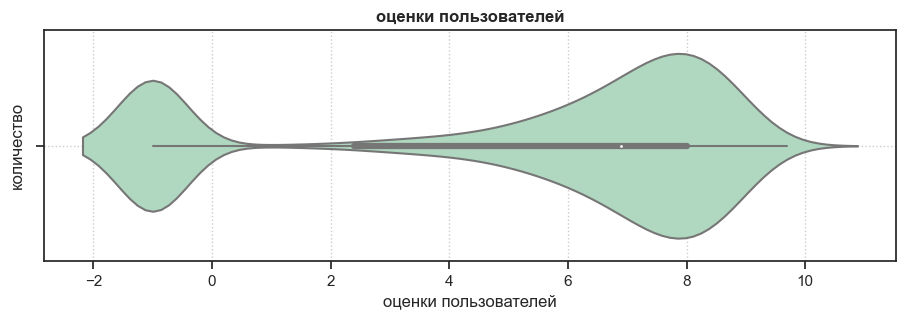

In [28]:
RequestStatistics(df.user_score).get_violin('оценки пользователей')

Ну вот они все значения -1, бывшие tbd, которые без рейтинга, собрались одним весомым шматком, остальные рейтинги распределены более-менее равномерно. Если пользовательская оценка понадобится для дальнейшего анализа (а она понадобится), значение -1 будем отбрасывать.

Пропуски же пока оставим как есть.

Теперь признак **```critic_score```** - посмотрим на него:

[13. 17. 19. 20. 21. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. nan]

min=13.0

max=98.0


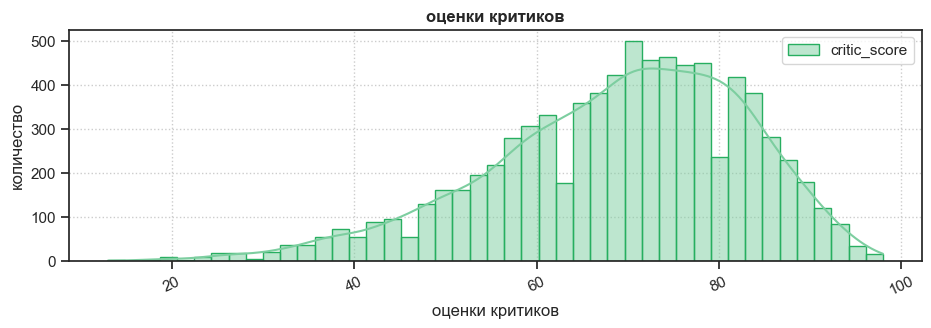

In [29]:
print(f"{np.sort(df['critic_score'].unique())}\n\n"
      f"min={df['critic_score'].min()}\n\nmax={df['critic_score'].max()}")
RequestStatistics(df.critic_score).get_hist('оценки критиков')

Те данные, что есть, распределены более-менее прилично, как два выколотых зуба есть два падения на 62 и 80, вполне возможно, что в т.ч. этих значений нам и не хватает. Кстати, отсутствующие значения в ```critic_score```, ```user_score``` и ```rating``` в большинстве своём пересекаются, что говорит в пользу предположения о том, что пропуски в них могут иметь технический характер:

In [30]:
df.query('critic_score.isna() and user_score.isna() and rating.isna()').shape[0]

6533

Пропуски в ```critic_score``` чем-то осмысленным заполнить не получится, оставим их как есть

Посмотрим внимательней и на **```rating```**. Он от [ESRB](https://www.esrb.org/) (вот о нём русскоязычная статья в [Википедии](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board)) и значения у нас такие:

In [31]:
df['rating'].value_counts()

e       3920
t       2906
m       1536
e10+    1393
ec         8
k-a        3
rp         1
ao         1
Name: rating, dtype: int64

Разберёмся, что означают буквы:

- **E** - Подходит для всех возрастных категорий.
- **T** - Подходит для лиц старше 13 лет.
- **M** - Подходит для лиц старше 17 лет.
- **E10+** - Подходит для лиц старше 10 лет. 
- **EC** - Для детей младшего возраста. 
- **K-A** - "Kids to Adults" - для детей от 6-ти лет и взрослых. После 1998-го года отнесён к **E10+**
- **RP** - Категория ещё не присвоена
- **AO** - Подходит для взрослых старше 18 лет.

Как видим, все рейтинги имеют место быть, **K-A** только устарел, заменим его на **E10+**, а **AO** есть только один, отнесём его к **M**

Причиной появления пропусков в рейтинге от ESRB может быть банально и то, что такого рейтинга для игры просто нет, так как у нас данные от 80-х годов, тогда как год основания комнапии ESRB 1994 г. Или наверняка ведь не все игры ESBR оценивает. Так что по пропускам в признаке решение такое - так как на отсутствующие значения мы рейтинг нафантазировать не можем, а признак строковый, то и заполним эти пропуски строкой *no information*. 

In [32]:
df['rating'].replace({'k-a': 'e10+', 'ao': 'm'}, inplace=True)
df['rating'].fillna('no_information', inplace=True)

Посмотрим на распределение:

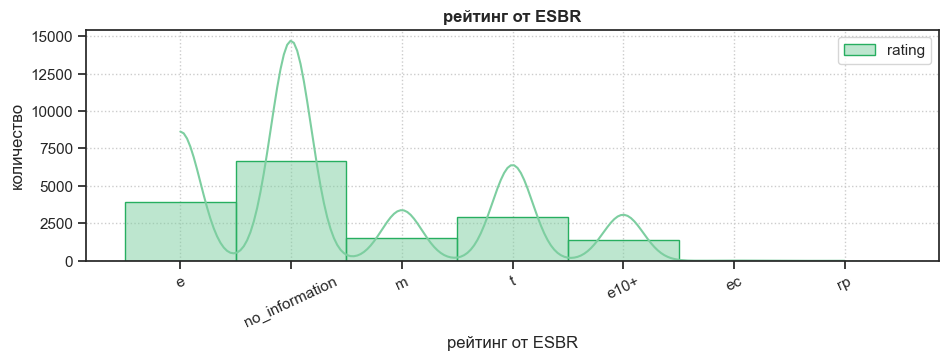

In [33]:
RequestStatistics(df.rating).get_hist('рейтинг от ESBR')

Существенная часть данных отсутствует, это настораживает, но пока оставим как есть.

У признаков с ценой и у ```na_sales```, ```eu_sales```, ```p_sales```, ```other_sales```, ```critic_score``` и ```user_score``` тип с float на int менять не будем, так как для количества проданных копий значения даны в миллионах и это было бы слишком грубым округлением.

Для остальных float-признаков округлим значения:

In [34]:
float_cols = ['critic_score', 'user_score']
df[float_cols] = df[float_cols].round(2)

In [35]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,no_information
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,no_information


**Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.**

In [36]:
df['total_sale'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sale
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,no_information,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,no_information,31.38


**Предварительный вывод:** на данном этапе мы:

- привели названия признаков к нижнему регистру, теперь названия соотвестсвуют стилю snake_case
- текстовые значения признаков, там где таковые есть, также привели к нижнему регистру, это позволит нам содержать текстовую информацию в едином формате и обезопасит от ошибок, связанных с написанием слов в разных регистрах "как попало"
- изменили тип данных в столбцах с датой релиза ```year_of_release``` и пользовательской оценкой ```user_score```
- для тех float-признаков ```critic_score``` и ```user_score``` округлили значения
- обработали пропуски там, где это оказалось возможным:
    - ```name``` и ```genre``` - удалили 2 пропуска
    - ```year_of_release``` - удалили записи без указания года выпуска (это 1.6% информации)
    - пропуски в ```critic_score```, ```user_score``` и ```rating``` заполнить адекватными начениями не представляется возможным, необходимо уточнять причину потери информации. Пока же бегло проанализировали то, что есть и:
          - в user_score заменили значение tbd и 0 на -1
          - в rating заменили пропуски на no_information, категорию K-A, как устаревшую на E10+, а AO как малочисленную добавили к многочисленному M
- сгенерироваои новый признак ```total_sale``` - это суммарные продажи во всех регионах

_____
_____

### Шаг 3. Проведём анализ данных

Посмотрим, сколько игр выпускалось в разные годы:

year_of_release:
среднее = 2006.4859, медиана = 2007.00, ср.отклонение = 5.88, сумма = 32992648.00, min = 1980.00, max = 2016.00


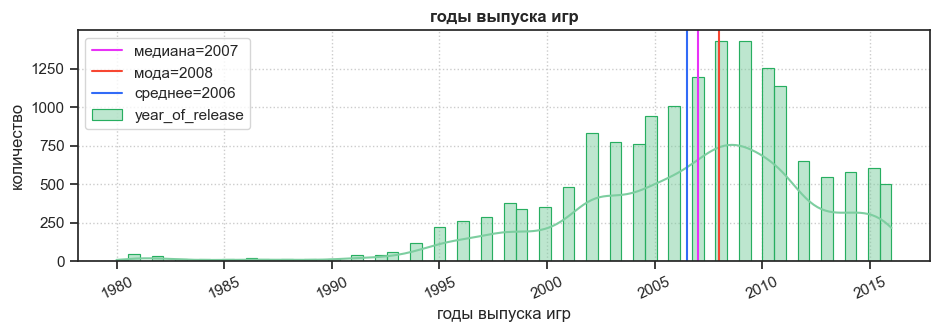

In [37]:
RequestStatistics(df.year_of_release).get_hist('годы выпуска игр', median=True, mode=True, mean=True)
RequestStatistics(df.year_of_release).description()

In [38]:
df.year_of_release.describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

Года так с 1995-го популярность игровой индустрии стала набирать обороты и количество выпускаемых игр по годам резко пошло вверх, достигнув пиковых значений в 2008-2009-х гг. Снижение количества выпускаемых игр можно объяснить:
- переходом от количества к качеству 
- бóльшим выходом не новых релизов, но обновлений и дополнений уже известных топовых игр
- переходом на подписную модель и новые формы монетизации в игровой индустрии
- трендом на мобильность игровых приставок  

Наши данные охватывают временной период в 35+ лет. За такой срок игровая индустрия несколько раз перевернулась с ног на голову, а потом обратно, сменилось несколько поколений игроков, буквально трансформировалось само представление об игре как таковой. Интересно и занятно было бы потешить свои старые кости и порассуждать о важности игр прошлого века, но практической коммерческой пользы для интернет-магазина "Стримчик" от игр, выпущенных до эпохи интернета и вообще тогда, когда слово "Стримчик" не имело никакого значения, вряд ли найдётся. Поэтому целесообразней будет в дальнейшем исследовании ограничиться более актуальными сроками. А вот какими будут эти сроки, сейчас определим.

Базовые статистики признака в распределении расположились рядом друг с другом (2006-2008 гг.), среднеквадратичное отклонение = 5.8, пик индустрии начинается года так с 2002-го (это, кстати, очень интересный на релизы год, вот [статья](https://ru.wikipedia.org/wiki/2002_%D0%B3%D0%BE%D0%B4_%D0%B2_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D1%85_%D0%B8%D0%B3%D1%80%D0%B0%D1%85) об играх, которые выходили в 2002-м, тут *GTA:Vice City* и *Hitman 2* и *FIFA 2003* и мн. др. локомотивы, которые выросли в отдельные бренды и гремят и по сей день)

$\Rightarrow$ допустим, что рассматривать данные можно с начала XXI-го века, т.е. с 2000-го года, отбросив 12% от изначального размера датафрейма:

In [39]:
f"{1-df[df['year_of_release'] >= 2000].shape[0] / size_at_start:.2%}"

'13.43%'

Достаточно ли этого? Прежде чем окончательно принимать решение, посмотрим, как менялись продажи по разным платформам в разные годы. Для начала найдем тех, кто за всё время продавал больше 50 млн. копий, будем считать их "успешными" игроками рынка:

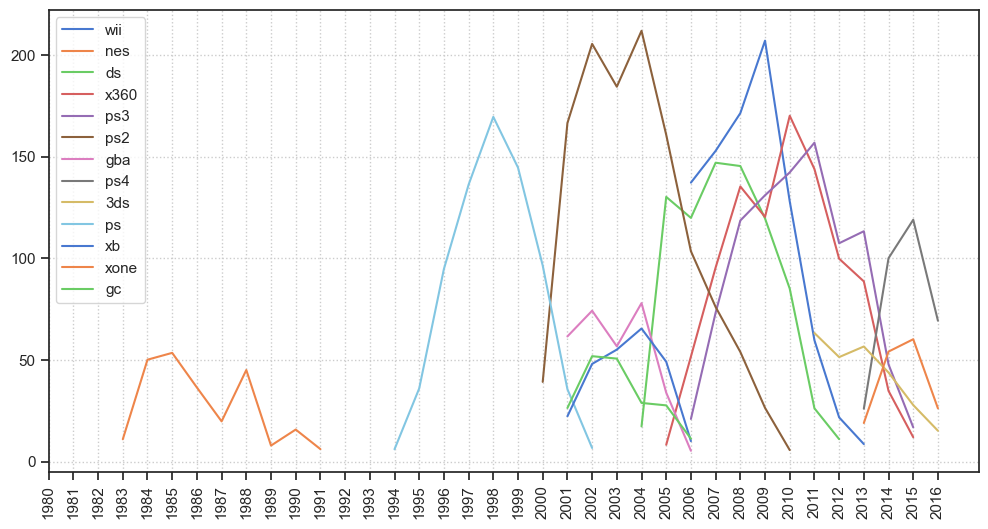

In [40]:
RequestStatistics().get_plot(df, quantity=50)

На безумном графике, что мы получили, видно то, что наша идея о необходимости оставить только XXI век, имеет под собой основания и вот почему: 
- В 80-е XX века была несомненным лидером была одна коммерчески успешная игровая платформа - это [Nintendo Entertainment System (NES)](https://love80s.ru/history/85/10/18/nes_release/history/)
- В 90-х года флаг первенства перехватила [PlayStation 1](https://ru.wikipedia.org/wiki/PlayStation)
- C 2000-го монополия какой-то одной игровой платформы проходит и в индустрии появляется всё больше новых интересных конкурирующих друг с другом игроков. Правда коммерчески успешный срок их жизни уже не исчисляется десятилетием. К примеру, такие игроки как [Wii](https://ru.wikipedia.org/wiki/Wii), [Game Boy Advance](https://ru.wikipedia.org/wiki/Game_Boy_Advance) или [Nintendo GameCube](https://ru.wikipedia.org/wiki/Nintendo_GameCube) (Nintendo GameCube) подержались на плаву в первой половине 00-х порядка 5-7-ми лет, да и исчезли. На смену им пришли новые компании.
- При этом стоит отметить, что на рынке остаются такие основные монстры индустрии, как [PlayStation 3](https://ru.wikipedia.org/wiki/PlayStation_3) и их главный конкурент [Xbox 360](https://ru.wikipedia.org/wiki/Xbox_360) в 2004-2014-х гг. они продолжают занимать лидирующие позиции.
- где-то с 2013-го года мы видим общий тренд на снижение продаж игр по всем платформам. Этот тренд был явно виден раньше и на гистограмме
- и интересный факт - с 2011-го года в лидеры рынка вновь выходит компания Nintendo с карманной приставкой [Nintendo 3DS](https://ru.wikipedia.org/wiki/Nintendo_3DS), в списке игр у которой те самые игры, с которыми компания выстрелила ещё на рубеже 80-90-х: Super Mario, Luigi's Mansion, The Legend of Zelda и др. Предположим, что это можно объяснить трендом на мобильность игровых устройств. Этот же тренд, возможно, объясняет снижение количества продаваемых копий игр по всему миру для стационарных игровых приставок. Вот так, с Nintendo обзор начали, Nintendo и закончили)

$\Rightarrow$ данными за 80-90-е годы прошлого века точно можно пренебречь, так как они не отвечают общим современным трендам развития игровой индустрии, а сами компании того времени вполне себе и в XXI веке остаются в лидерах рынка. Правильней было бы обратить внимание на современный подход к игровой индустрии в этих компаниях, общий тренд на компактность игровых платформ, новую подписную модель продаж и устойчивый интерес к "играм-ветеранам", который проходит буквально через все десятилетия наблюдений.

Посмотрим, сколько по среднему живут игровые платформы в XXI веке:

In [41]:
np.quantile(
    df[df['year_of_release'] >= 2000].pivot_table(
        index='year_of_release', 
        columns='platform', 
        values='total_sale', aggfunc='sum')
    .notna().sum(), q=0.5 
)

6.5

6.5 лет. Это даже оптимистично и во многом такая цифра получается за счёт таких долгоживущих гигантов как PlayStation. Но ещё из графика &uarr;&uarr;&uarr; мы знаем, что пики коммерчески успешного "жизненного цикла" платформ с 2010-го года держатся где-то на уровне 4-х лет

$\Rightarrow$ для прогноза на 2017-й оттолкнёмся от данных начиная с 2013-го года, т.е. за последние 4 года:

In [42]:
df_new_age = df.loc[(df['year_of_release'] >= 2013)&(df['total_sale'] != 0)]

Прежде чем что-то анализировать, проверим ещй раз, какие игровые платформы попали в выбранный нами период, и сравним год выхода игр на них с годом релиза самой платформы. Игры не должны быть старше:

In [43]:
df_new_age.groupby('platform')['year_of_release'].min()

platform
3ds     2013
ds      2013
pc      2013
ps3     2013
ps4     2013
psp     2013
psv     2013
wii     2013
wiiu    2013
x360    2013
xone    2013
Name: year_of_release, dtype: int16

Вроде нет ничего криминального. Самые свежие молодые платформы из списка как раз вышли на рынок в 2013-м году, как и игры к ним.

Посмотрим изменение количества в млн. проданных копий игр и сумм от них:

In [44]:
pivot_descr = df_new_age.pivot_table(index='year_of_release', 
                                     columns='platform', 
                                     values='total_sale', 
                                     aggfunc=['count', 'sum'])

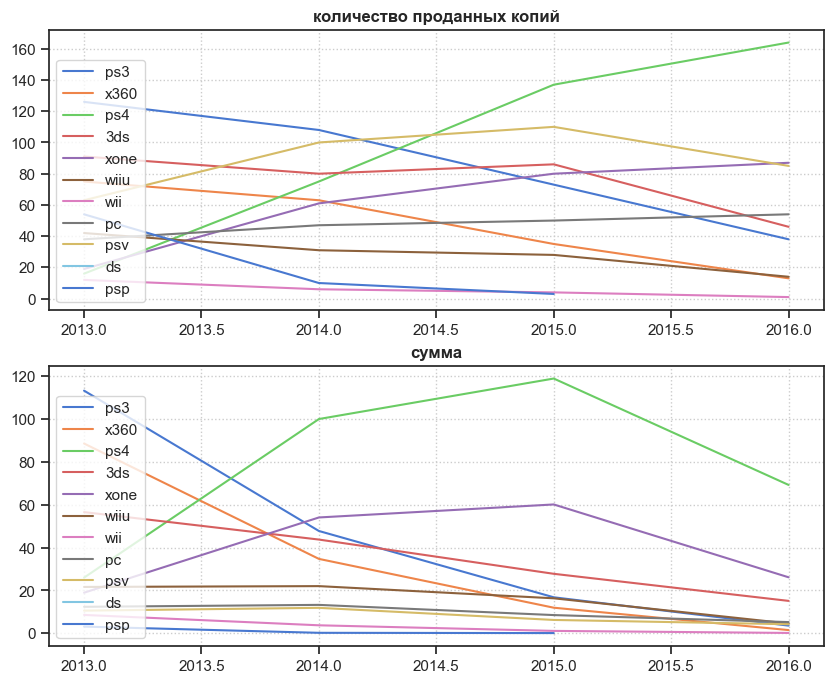

In [45]:
RequestStatistics().get_lineplot(df_new_age, pivot_descr)

По графикам на фоне остальных платформ потенциально прибыльными на 2017-й год остаются платформы с растущим количеством продаж проданных копий игр - это PlayStation4, карманная [PlayStation Vita](https://ru.wikipedia.org/wiki/PlayStation_Vita), Xbox One и Nintendo 3DS.

При этом мы видим, что за последние 4 года, даже не смотря на рост продаж количества копий игр для PlayStation, Xbox One и Nintendo 3DS, сумма денег от них снижается, поэтому делать серьёзную ставку на кого-то одного было бы опрометчиво и стоит подумать о диверсификации инвестиций по разным "корзинам" в грядущем году. 

Посмотрим на эти значения ещё и на барплотах, но только на потенциально прибыльных и интересных для 2017-го года платформах:

X360
total_sale:
среднее = 0.7355, медиана = 0.27, ср.отклонение = 1.66, сумма = 136.80, min = 0.01, max = 16.27

PS4
total_sale:
среднее = 0.8014, медиана = 0.20, ср.отклонение = 1.61, сумма = 314.14, min = 0.01, max = 14.63

3DS
total_sale:
среднее = 0.4728, медиана = 0.09, ср.отклонение = 1.38, сумма = 143.25, min = 0.01, max = 14.60

XONE
total_sale:
среднее = 0.6450, медиана = 0.22, ср.отклонение = 1.04, сумма = 159.32, min = 0.01, max = 7.39

PC
total_sale:
среднее = 0.2086, медиана = 0.08, ср.отклонение = 0.35, сумма = 39.43, min = 0.01, max = 3.05

PSV
total_sale:
среднее = 0.0922, медиана = 0.04, ср.отклонение = 0.15, сумма = 32.99, min = 0.01, max = 1.96



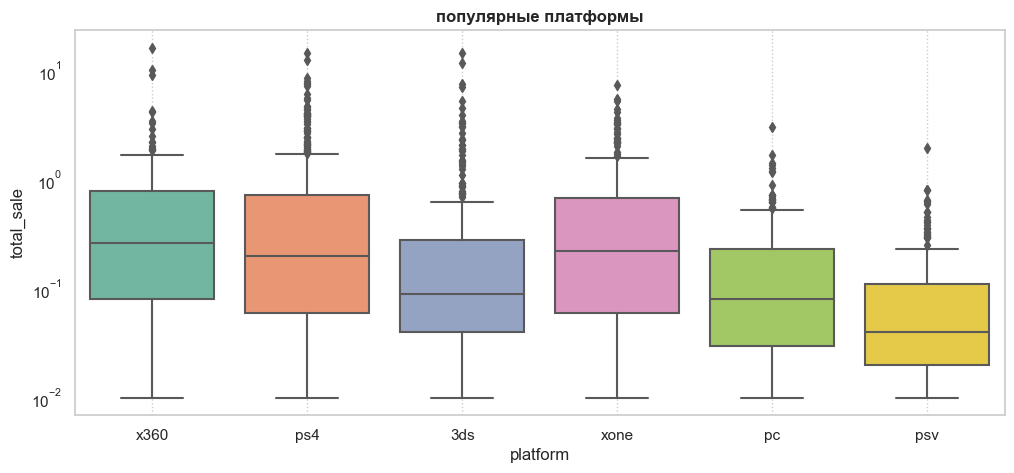

In [46]:
best_platforms = ['x360', 'ps4', '3ds', 'xone', 'pc', 'psv']
RequestStatistics().get_boxplot(df_new_age, best_platforms)
for i in best_platforms:
    print(i.upper())
    RequestStatistics(df_new_age.loc[df_new_age.platform == i, 'total_sale']).description()
    print()

В лидерах PlayStation4, Xbox One, ПК-игры и карманные платформы, в особенности Nintendo 3DS. У PlayStation4 и Xbox One есть настоящие хиты продаж, оттого и такой разброс и разница между медианами (которые не сильно отличаются друг от друга) и средними (которые дают большой разлёт). Так как отдельные "выстрелы" из распределения соответствуют конкретным играм-хитам, то удалять их никак нельзя.

Посмотрим, что это за игры:

In [47]:
(
    df_new_age
    .pivot_table(index=['name', 'platform'], values='total_sale', aggfunc='sum')
    .reset_index().sort_values(by='total_sale', ascending=False).head(10)
)

,name,platform,total_sale
741,grand theft auto v,ps3,21.05
743,grand theft auto v,x360,16.27
249,call of duty: black ops 3,ps4,14.63
1404,pokemon x/pokemon y,3ds,14.60
742,grand theft auto v,ps4,12.62
1400,pokemon omega ruby/pokemon alpha sapphire,3ds,11.68
256,call of duty: ghosts,x360,10.24
253,call of duty: ghosts,ps3,9.36
1152,minecraft,x360,9.18
644,fifa 16,ps4,8.58


```GTA V``` - для PlayStation и Xbox с серьёзным отрывом от других на вершине продаж. И это соответствует действительности, так как игра была признана самой продаваемой игрой десятилетия (вот [статья](https://cyber.sports.ru/games/1082808838-gta-5-samaya-prodavaemaya-igra-desyatiletiya-rdr-2-lider-po-prodazham.html)). А для других игровых платформ она не издавалась (ну кропе ПК конечно). Убедимся в этом:

In [48]:
df_new_age.loc[df_new_age['name'] == 'grand theft auto v']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sale
16,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,m,21.05
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,m,16.27
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,12.62
165,grand theft auto v,xone,2014,action,2.81,2.19,0.00,0.47,97.0,7.9,m,5.47
1730,grand theft auto v,pc,2015,action,0.39,0.69,0.00,0.09,96.0,7.9,m,1.17


Так и есть, игра обнаружена только для разных версий для PlayStation, Xbox и ПК, другим приставкам не досталось. Увы, как говорится, и ах, бизнес и ничего личного.

Проверим, сколько пропусков у нас осталось в ```critic_score``` и ```user_score``` и посмотрим, как влияют на продажи отзывы:

In [49]:
print(f"пропусков:\n{df_new_age[['critic_score','user_score']].isna().sum()}\n\nа всего:{df_new_age.shape[0]}")

пропусков:
critic_score    1242
user_score       933
dtype: int64

а всего:2233


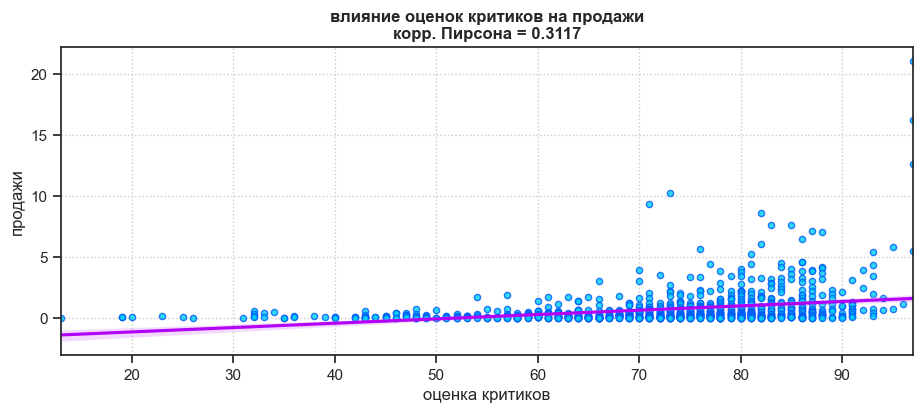

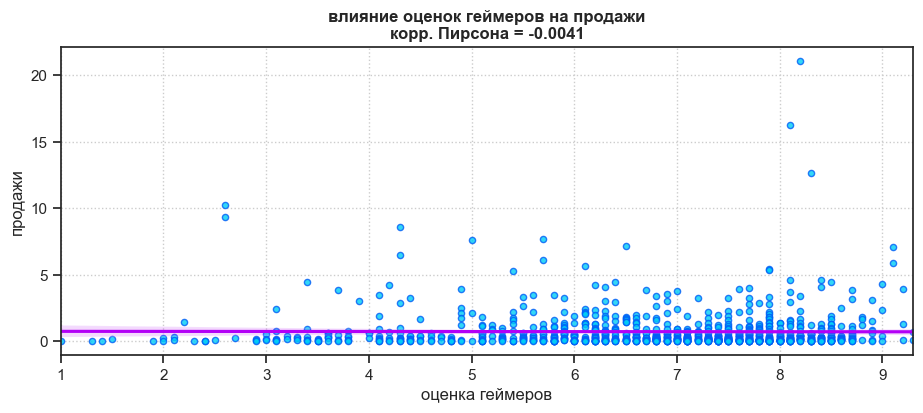

In [50]:
df_dropna = df_new_age.dropna()
df_dropna = df_dropna[~(df_dropna['user_score'] == -1)]
RequestStatistics(df_dropna.total_sale, df_dropna.critic_score).get_regplot(
    ['продажи', 'оценок критиков', 'оценка критиков'])
RequestStatistics(df_dropna.total_sale, df_dropna.user_score).get_regplot(
    ['продажи', 'оценок геймеров', 'оценка геймеров'])

Судя по диаграмме рассеяния и коэффициенту корреляции Пирсона выходит так, что оценка критиков имеет значение. Корреляция 0.31 говорит о том, что покупатели таки прислушиваются к экспертному мнению критиков и исходя из этого мнения принимают решение о покупке. Но происходит это не всегда. 

А вот влиния пользовательских оценок на продажу никакого нет, что, конечно, может показаться странным. Однако не стоит забывать о том, что практически половина данных по этим признакам у нас отсутствует, поэтому полученная информация требует уточнения и сейчас на её основе нельзя принимать коммерческих решений по формированию стратегии развития "Стримчика" на 2017-й год.

Посмотрим, как дело обстоит отдельно по каждой платформе:

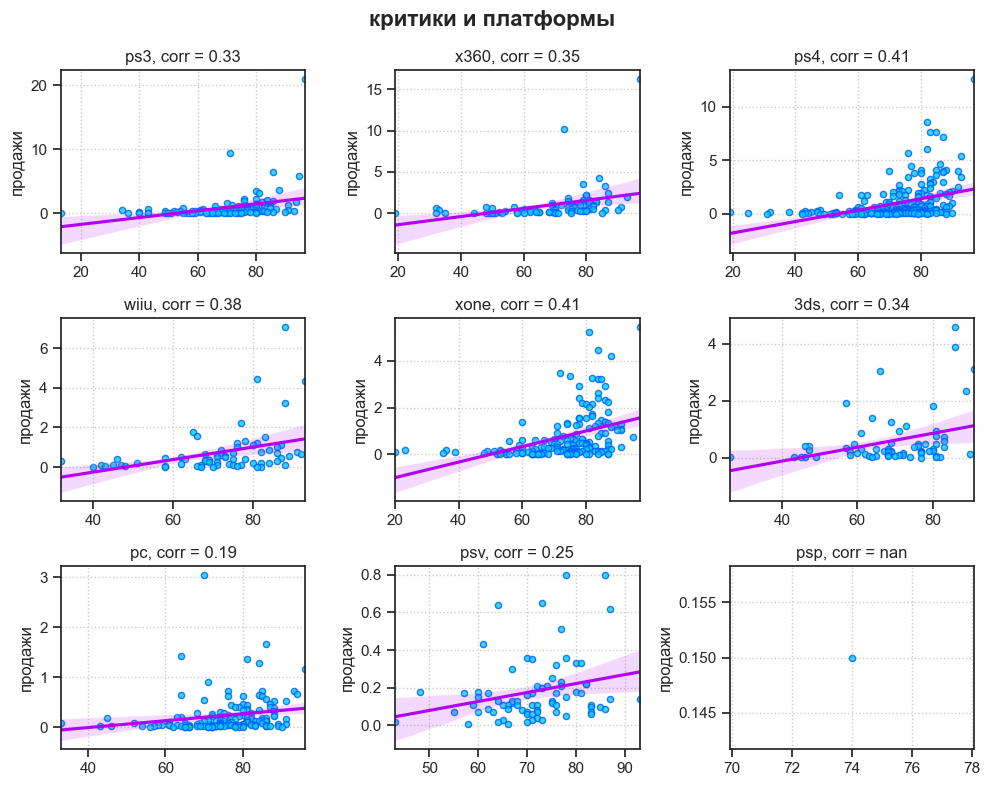

In [51]:
(
    RequestStatistics(df_dropna.total_sale, df_dropna.critic_score, df_dropna).
    get_regplot_many_charts(df_dropna.platform.unique(), 'platform', 'критики и платформы')
)

Больше всего от оценки критиков зависят продажи игр для консолей - ```PlayStation``` и ```Xbox```, особенно новых. Это легко объясняется мировой известностью компаний и их заботой о своей репутации. Их названия у всех на слуху, за их релизами внимательно следят во всём мире, выпусков популярных игр ждут тысячи поклонников. Неудивительно, что оценки критиков важны для них. О ```PlayStation``` и ```Xbox``` и пишут-то, наверное, вдвое больше, чем о всех остальных вместе взятых.

Зависимой оказалась и японская [Wii U](https://ru.wikipedia.org/wiki/Wii_U) от ```Nintendo``` - это карманная версия стационарной платформы Wii, значит и японцам не всё равно на рецензии и отзывы критиков, свою карманную приставку они любят.

Все корреляции положительные, следовательно, чем выше оценка от критиков, тем больше продаж игр. Но, опять же, помним, что данных у нас в признаке мало, так что, хоть выводы и кажутся правильными и логичными, опираться на них как на точную истину нельзя.

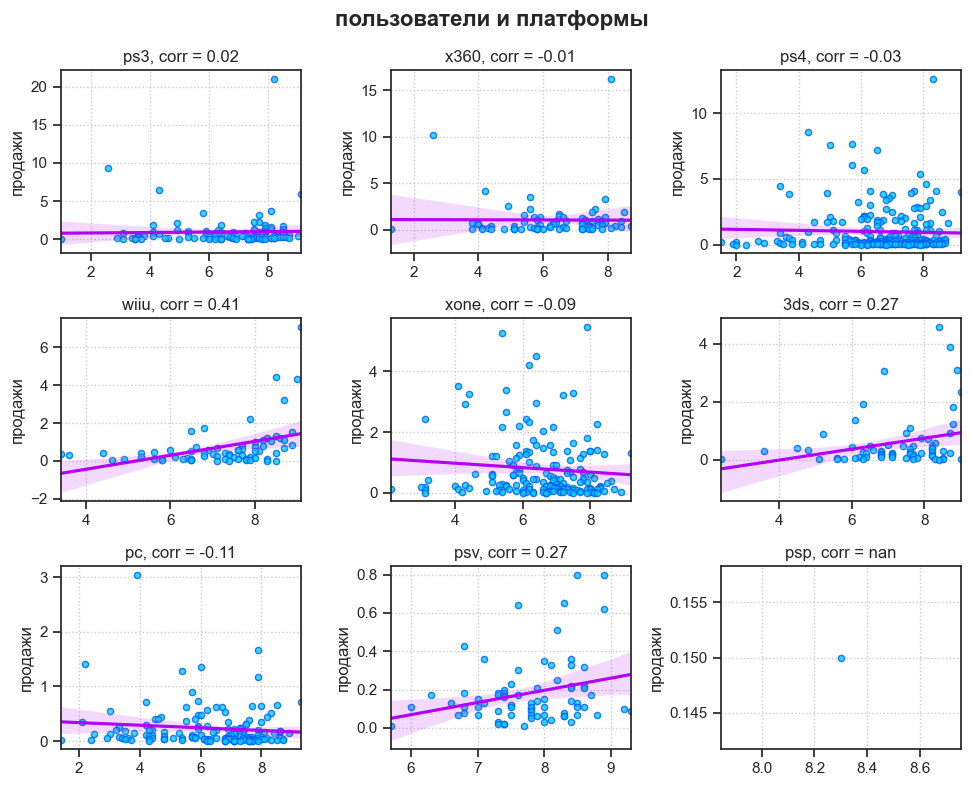

In [52]:
(
    RequestStatistics(df_dropna.total_sale, df_dropna.user_score, df_dropna).
    get_regplot_many_charts(df_dropna.platform.unique(), 'platform', 'пользователи и платформы')
)

In [53]:
def get_pie(p1, p2, p3, p4, t=False, t_list=None): 
    '''
    метод строит несколько pie в объекте фигуры в формате 2x2
    :param p1, p2, p3, p4: данные, t, t_list: опционально (заголовки)
    :return: plt.pie() 
    '''
    sns.set(style='whitegrid', palette='Set2')
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    if t:
        fig.suptitle(t, fontsize=16, fontweight='bold')
    ax1, ax2, ax3, ax4 = ax.flatten()
    ax1.pie(p1, labels=p1.index, autopct='%1.1f%%', textprops={'fontsize': 8}, pctdistance=0.8)
    ax1.set_title(f'{t_list[0]}', fontweight='bold')
    ax1.axis('equal')
    ax2.pie(p2, labels=p2.index, autopct='%1.1f%%', textprops={'fontsize': 8}, pctdistance=0.8)
    ax2.set_title(f'{t_list[1]}', fontweight='bold')
    ax2.axis('equal')
    ax3.pie(p3, labels=p3.index, autopct='%1.1f%%', textprops={'fontsize': 8}, pctdistance=0.8)
    ax3.set_title(f'{t_list[2]}', fontweight='bold')
    ax3.axis('equal')
    ax4.pie(p4, labels=p4.index, autopct='%1.1f%%', textprops={'fontsize': 8}, pctdistance=0.8)
    ax4.set_title(f'{t_list[-1]}', fontweight='bold')
    ax4.axis('equal');

В отзывах пользователей совершенно другая картинка. Кроме всё тех же японских игрушек-малышек ```Wii U```, ```Nintendo 3DS``` и карманной ```PlayStation Vita``` все остальные корреляции ниже 0.3

В целом, при наличии такого большого количества пропусков в данных, как у нас в признаке ```user_score```, значениями корреляции ниже 0.3 можно пренебречь.  Данная информация требует уточненияи и на неё нельзя с уверенностью пологаться как на достоверную.

Посмотрим теперь на общее распределение по жанрам:

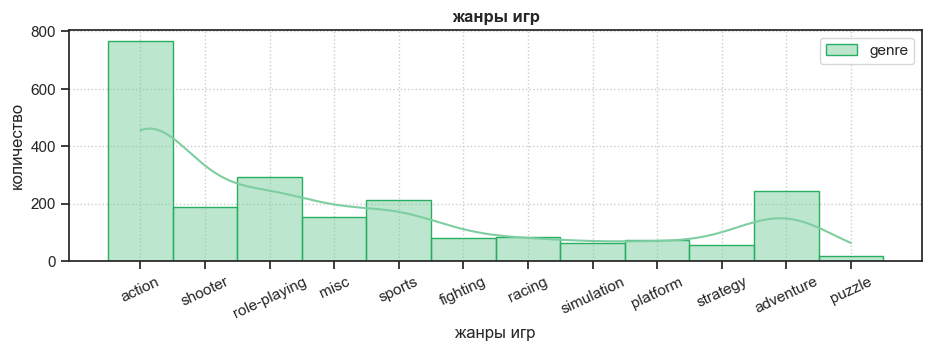

In [54]:
RequestStatistics(df_new_age.genre).get_hist('жанры игр')

Экшены - самый топовый жанр по количеству проданных единиц. Он, так сказать, даёт прикурить всем стальным жанрам, не уступая пъедестал почёта. Но помимо него есть и другие молодцы, ТОП-5 жанров будет выглядеть так:
1) экшен
2) ролевые
3) приключения
4) спортивные
5) шутеры

-1) а вот пазлы никто не любит, интересно почему) и как они попали в ряд с такими серьёзными жанрами? Наверное опять японцы руку приложили со своими игровыми таблетками.

А что по деньгам? Проверим:

,count,sales,median
genre,,,
shooter,187,232.98,0.450
sports,214,150.65,0.240
platform,74,42.63,0.225
role-playing,292,145.89,0.125
fighting,80,35.31,0.125
racing,85,39.89,0.120
action,766,321.87,0.110
simulation,62,21.76,0.100
misc,155,62.82,0.100


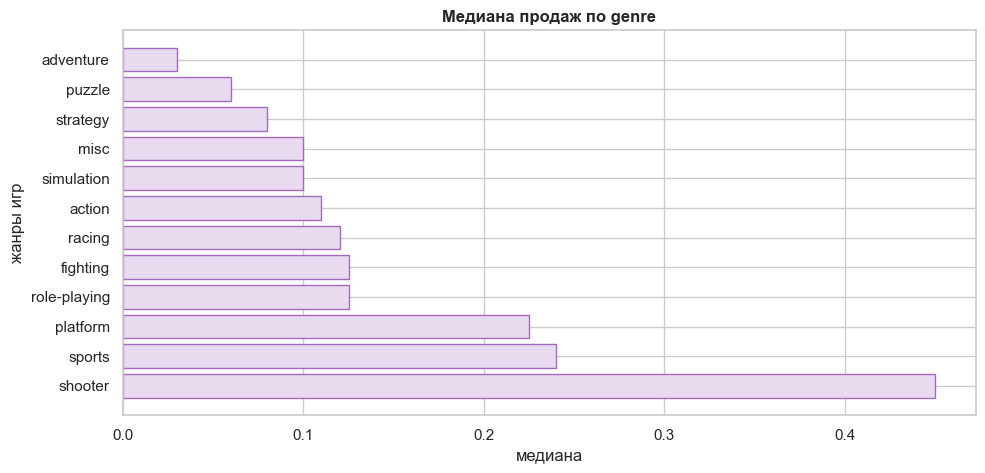

In [55]:
question = (
    df_new_age.groupby('genre')['total_sale']
    .agg(count='count', sales='sum', median='median')
    .sort_values('median', ascending=False)
)
RequestStatistics().get_barh(question, 'жанры игр')
question

Вот так неожиданность - приключенческий жанр adventure попал в ТОП-5 по количеству проданных экземпляров игр, при этом, какой стыд, денег он принёс меньше пазлов. Можно допустить, что игры этого жанра хорошо используются как маркетинговая приманка - в качестве бесплатного подарка или дополнительного предложения для увеличения роста лояльности и привлечения новых пользователей к своим приставкам. Отдельные же хиты жанра должны быть просто максимально популярными и, как следствие, из-за высокой конкуренции и высокой эластичности спроса, на них заработать нормально и не получается. 

Основные же доходы собрались здесь:

1) экшены
2) шутеры
3) спортивные
4) ролевые
5) misc (всё подряд) и
6) платформеры (для любителей попрыгать)

При этом медиана самая высокая у шутеров, а значит и продажи от них должны быть самыми прибыльными и прогнозируемыми

Проверим и самые популярные по деньгам платформы, кто же это кто:

,count,sales,median
platform,,,
x360,186,136.80,0.265
xone,247,159.32,0.220
ps4,392,314.14,0.200
wiiu,115,64.63,0.200
wii,23,13.66,0.180
ds,8,1.54,0.150
ps3,345,181.43,0.150
3ds,303,143.25,0.090
pc,189,39.43,0.080


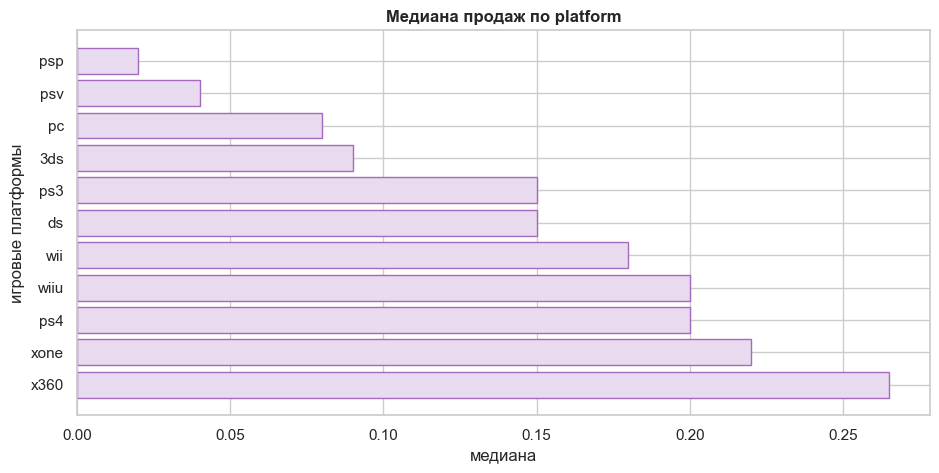

In [56]:
question = (
    df_new_age.groupby('platform')['total_sale']
    .agg(count='count', sales='sum', median='median')
    .sort_values('median', ascending=False)
)
RequestStatistics().get_barh(question, 'игровые платформы')
question

Несмотря на более-менее одинаковую медиану у лидеров игрового рынка, самыми выгодными по деньгам оказываются игры для Xbox, хоть и продаётся их меньше, чем игр для PlayStation. И хоть у платформ нет такой существенной разницы в доходности, как у игровых жанров, эту информацию следует учитывать при составлении маркетинговой стратегии развития продаж на 2017 год.

**Предварительный вывод:** на данном этапе мы проделали большую работу по исследованию данных и вот что выяснили:

- изучили выход игр по годам, определили для себя важный период, на который дальше опирались при проведении исследовательского анализа. Решили так:
    - для общего знакомства с рынком обзорно опираемся на игры, выпускаемые с начала 2000-х
    - а для прогноза на 2017-й год определяем контрольный период времени, в который вошли данные с начала 2013-го года (диапазон 4 последних года)
    
    
- высянили коммерчески успешный жизненный цикл игровой платформы - это 6.5 лет, причём в последние годы этот срок заметно сокращается
- определили лидеров по продажам за контрольный период, ими оказались PlayStation4, PlayStation Vita, Xbox One и Nintendo 3DS
- при этом выявили закономерность, заключающуюся в том, что, несмотря на рост продаж количества копий игр, денег от них приходит меньше. Это наблюдение позволяет сделать предположение о том, что ставить на какую-то одну игровую площадку в 2017-м году рискованно и компании "Стримчик", помимо игровых платформ, стоит рассмотреть инвестиции в развитие и других, смежных игровому, направлениях. Необходимо более детально разобраться в том, "куда уходят деньги" из игр и что находится в тренде за последние пару лет. Одни из возможных причин падения спроса на игровые приставки - это:
    - более широкое применение подписной модели обслуживания клиентов и, как следствие, продажи игр и обновлений к ним в формате online. Такой подход к продажам исключает необходимоть трат на производство и распространение физических копий игр и этот факт мог отразиться на стоимости игр.
    - или всё дело в том, что люди охотнее переходят на более компактные игровые гаджеты.


- оценили влияние отзывов на продажи игр. Отдельно рассмотрели как отзывы критиков, так и отзывы покупателей, как отзывы по всем платформам сразу, так и по наиболее популярным в отдельности. И несмотря на то, что данных для корректного иссдедования влияния отзывов на продажи у нас не так много, некий общий тренд всё же уловить удалсь, а именно:
    - продажи игр от больших платформ, таких как PlayStation и Xbox, имеют прямую корреляцию с отзывами критиков - чем выше оценка критиков, тем лучше продажи. Так что на рецензии к играм стоит обращать внимание.
    - а пользовательские отзывы влияют на продажи разве что китайских карманных приставок. Такие приставки - своя особая игровая индустрия и маркетинговая стратегия на 2017-й год для карманных платформ должна быть своей.
    
    
- оценили общее распределение по игровым жанрам, нашли ТОП-5 самых продаваемых и ТОП-5 самых доходных жанров, выявили интересную закономерность:
    - вкладываться в adventure не стоит, но ассортимент игр этого направления нужно всегда иметь в достаточной представленности, так как их хорошо использовать как "приманку" для привлечения покупателей к своей платформе, ведь продаются они хорошо, но доход с них минимальный.
    - при этом жанр action тоже не самый доходный, однако игр этого жанра продаётся больше всего, что говорит о высокой конкурентности в данном направлении и, как следствие, низкой маржинальности. Для маркетинга это важный жанр, за ним нужно постоянно и внимательно следить, держать руку на пульсе. Любое отклонение в динамике продаж игр action будет сигнализировать об изменениях трендов игровом бизнесе в целом.
    - shooter - самый доходный жанр, на порядок опережающий остальные. Эти игры есть смысл рекламировать, о их наличии у себя интернет-магазину "Стримчик" стоит трубить во все трубы. 
    
Для бóльшей кастомизации маркетинговых предложений в 2017-м году хорошо было бы получить и дополнительно изучить сведения о покупателях игр разных жанров - кто, возраст, предпочтения, регион проживания и пр.

Изученные данные помогли погрузиться в материал исследования и позволили сформулировать ряд промежуточных выводов, которые должны помочь нам в дальнейшей работе.

_____
_____

### Шаг 4. Составим портрет пользователя для каждого региона

**Посмотрим на распределение продаж в разных частях света:**

In [57]:
na = df_new_age.groupby('platform')['na_sales'].sum().round()
na_ = na.sort_values().tail(7)
na_new_value = pd.Series({**na_.to_dict(), "остальные": na.sort_values().head(4).sum()})

eu = df_new_age.groupby('platform')['eu_sales'].sum().round()
eu_ = eu.sort_values().tail(7)
eu_new_value = pd.Series({**eu_.to_dict(), "остальные": na.sort_values().head(4).sum()})

jp = df_new_age.groupby('platform')['jp_sales'].sum().round()
jp_ = jp.sort_values().tail(7)
jp_new_value = pd.Series({**jp_.to_dict(), "остальные": na.sort_values().head(4).sum()})

other = df_new_age.groupby('platform')['other_sales'].sum().round()
other_ = other.sort_values().tail(7)
other_new_value = pd.Series({**other_.to_dict(), "остальные": na.sort_values().head(4).sum()})

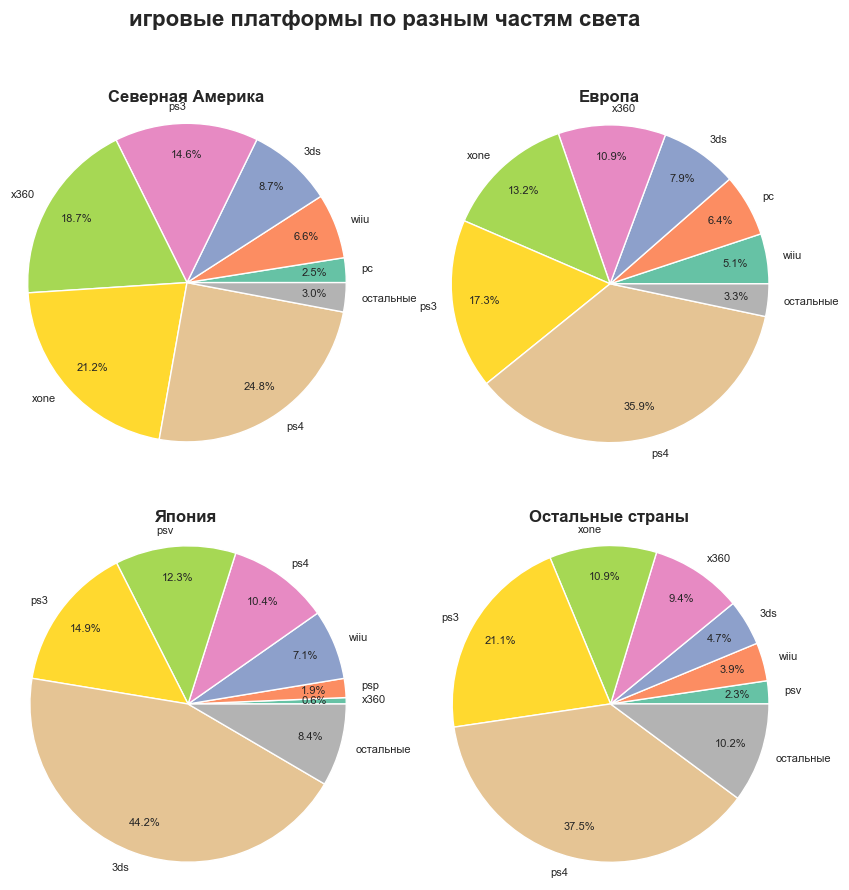

In [58]:
RequestStatistics().get_pie(na_new_value, 
                            eu_new_value, 
                            jp_new_value, 
                            other_new_value, t='игровые платформы по разным частям света',
                            t_list=['Северная Америка', 'Европа', 'Япония', 'Остальные страны'])

Видим вот такой наглядный расклад:
- в **Северной Америке** в лидерах:
    - Xbox - 39.9%
    - PlayStation - 39.4%
    - Nintendo - 15.3%
    - остальные по мелочи
   

- в **Европе** в лидерах:
    - PlayStation - 53.3% 
    - Xbox - 24.3%
    - Nintendo - 14.5%
    - ПК - 6.4% 
    - остальные по мелочи

    
- в **Японии** в лидерах:
    - Nintendo - 46.3%
    - PlayStation - 26.5%
    - карманная PlayStation Vita - 12.9%
    - карманная Wii U от Nintendo 7.5% 
    - остальные по мелочи
    
    
- в **других странах мира** в лидерах:
    - PlayStation - 62.9% 
    - Xbox - 21%
    - Nintendo - 8.8%
    - ПК - 2.5%
    - остальные по мелочи
    
Прочие игровые платформы представлены слабо

Получается, что в зависимости от рынка меняется и популярность платформ. 

Безусловным лидером игровой индустрии в мире является ```PlayStation```, в США ```PS``` и ```Xbox``` конкурируют друг с другом практически вровень. 

Стабильные 10-15% в мире - это любители ```Nintendo```.

Но что мы видим по Японии! Япония в мире игр, да как и в остальном, страна очень самобытная и больше половины игрового рынка в ней занято всевозможными ```карманными приставками```, 26% занимает ```PlayStation```, а для ```Xbox``` фактически не осталось места. Вообще история портативных игровых консолей в Японии богатая и интересная, вот [статья об этом на Хабре](https://habr.com/ru/company/timeweb/blog/572318/).

**Почему это важно для нас?** Дело в том, что при первом рассмотрении имеющихся данных мы предположили, что в мире наблюдается возрастающий интерес именно к портативным консолям, которые, в свою очередь, задали тренд на снижение количества продаваемых игр. Однако теперь мы видим, что тренд на карманные приставки в большинстве своём локализуется только в Японии, в США они представлены мало, а в Европе и мире занимают нишу чуть больше 5-ти %. 

$\Rightarrow$ если "уменьшение" игровых устройств до компактных размеров как-то и отразилось на снижении количества продаваемых игр в мире, то виноваты в этом скорее не игровые консоли, а мобильные телефоны и развитие мобильной игровой индустрии как нового рынка сбыта.

Интересно было бы изучить рост популярности мобильных игр. Цифр от компании "Стримчик" по этому вопросу у нас нет, зато есть интернет, который позволяет узнать много познавательного на этот счёт. Вот, к примеру, [статья в Нетологии](https://netology.ru/blog/12-2021-mobile-games-evolution) на эту тему. В статье использованы данные от аналитического центра data.ai. Заглянув в будущее и посмотрев на рост популярности мобильных игр от центра data.ai, мы можем видеть то, что на рубеже 2016-2017-гг. тренд на рост мобильной игровой индустрии уже был очевиден:

![GRAFIK-ROSTA-RAZNYK-SIGMENTOV-IGR.jpg](https://ltdfoto.ru/images/2023/03/15/GRAFIK-ROSTA-RAZNYK-SIGMENTOV-IGR.jpg)

**Стоит посмотреть ещё на то, какие жанры популярны на разных континентах:**

In [59]:
na = df_new_age.groupby('genre')['na_sales'].sum().round()
na_ = na.sort_values().tail(9)
na_new_value = pd.Series({**na_.to_dict(), "остальные": na.sort_values().head(3).sum()})

eu = df_new_age.groupby('genre')['eu_sales'].sum().round()
eu_ = eu.sort_values().tail(9)
eu_new_value = pd.Series({**eu_.to_dict(), "остальные": na.sort_values().head(3).sum()})

jp = df_new_age.groupby('genre')['jp_sales'].sum().round()
jp_ = jp.sort_values().tail(9)
jp_new_value = pd.Series({**jp_.to_dict(), "остальные": na.sort_values().head(3).sum()})

other = df_new_age.groupby('genre')['other_sales'].sum().round()
other_ = other.sort_values().tail(9)
other_new_value = pd.Series({**other_.to_dict(), "остальные": na.sort_values().head(3).sum()})

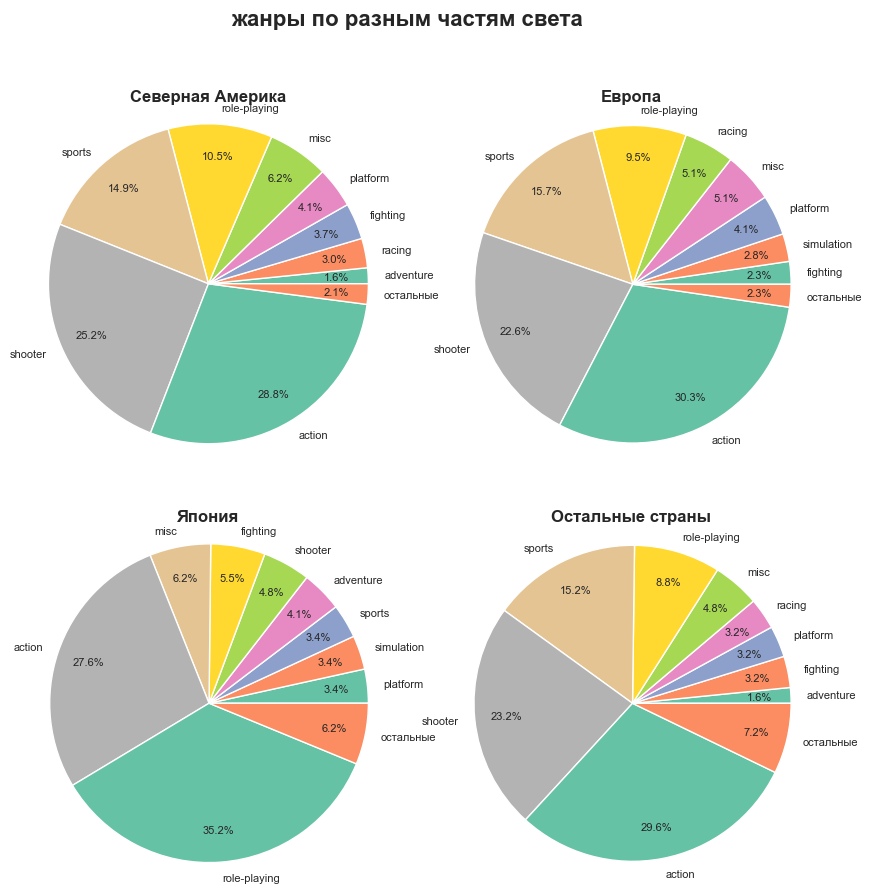

In [60]:
RequestStatistics().get_pie(na_new_value, 
                            eu_new_value, 
                            jp_new_value, 
                            other_new_value, t='жанры по разным частям света',
                            t_list=['Северная Америка', 'Европа', 'Япония', 'Остальные страны'])

Что мы видим:
- экшены популярны во всём мире, их доля составляет около 30%
- на втором месте в мире идут шутеры - 22-25%, 
- но только не в Японии. Стрелялкам и шутерам японцы предпочитают RPG-шки
- не любят японцы и спорт так, как остальные геймеры мира. Удивительный народ японцы) и при практически единообразных общих предпочтениях по всему миру они идут своим путём и выбирают что-то своё.

Итого, мы можем выделить ТОП-5 игровых жанров для разных частей света:
    
- в **Северной Америке** в лидерах:
     1) экшены - 28.8%
     2) шутеры - 25.2%
     3) спортивные - 14.9%
     4) ролевые - 10.5%
     5) misc (всё подряд) - 6.2%
   

- в **Европе** в лидерах:
     1) экшены - 30.1%
     2) шутеры - 22.4%
     3) спортивные - 15.6%
     4) ролевые - 9.4%
     5) misc (всё подряд) и гоночки делят 5-е место, у них по 5.1%

    
    
- в **Японии** в лидерах:
     1) ролевые - 35.9%
     2) экшены - 28.2%
     3) misc (всё подряд) - 6.3%
     4) драки - 5.6%
     5) шутеры - 4.9%
    
    
- в **других странах мира** в лидерах:
     1) экшены - 30.6%
     2) шутеры - 24%
     3) спортивные - 15.7%
     4) ролевые - 9.1%
     5) misc (всё подряд) - 5%
    

**Узнаем, влияет ли рейтинг ESBR на продажи на разных континентах:**

In [61]:
na = df_new_age.groupby('rating')['na_sales'].sum().round()
na_ = na.sort_values().tail(10)
na_new_value = pd.Series({**na_.to_dict()})

eu = df_new_age.groupby('rating')['eu_sales'].sum().round()
eu_ = eu.sort_values().tail(10)
eu_new_value = pd.Series({**eu_.to_dict()})

jp = df_new_age.groupby('rating')['jp_sales'].sum().round()
jp_ = jp.sort_values().tail(10)
jp_new_value = pd.Series({**jp_.to_dict()})

other = df_new_age.groupby('rating')['other_sales'].sum().round()
other_ = other.sort_values().tail(10)
other_new_value = pd.Series({**other_.to_dict()})

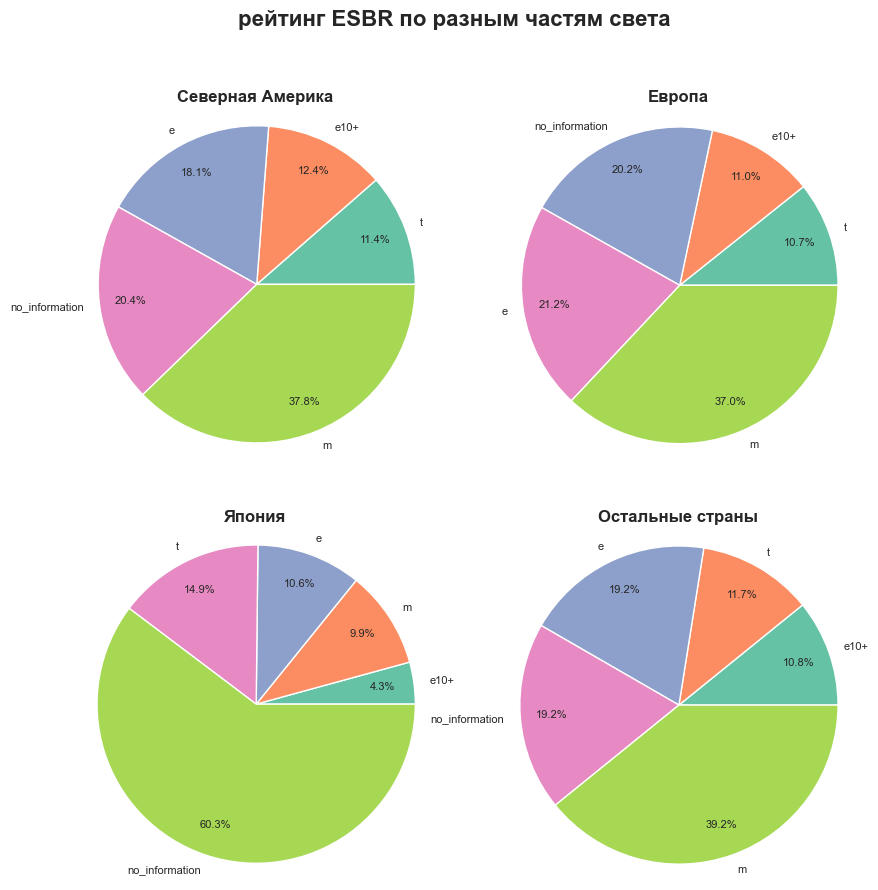

In [62]:
RequestStatistics().get_pie(na_new_value, 
                            eu_new_value, 
                            jp_new_value, 
                            other_new_value, t='рейтинг ESBR по разным частям света',
                            t_list=['Северная Америка', 'Европа', 'Япония', 'Остальные страны'])

К сожалению, большая часть данных по рейтингу от ESBR у нас отсутствует. Этот пропуск по своему тоже говорящий, так как мы видим, что для Японии упущено аж 60.3% от общего количества игр, тогда как для остального мира доля пропусков остаётся порядка 20%. Это может говорить о том, что рейтинг ESBR для продажи игр в Японии не имеет такого существенного значения и сильно не влияет на продажи. Ну и мы уже раньше узнали, что у Японцев своя песочница)) у них и приставки свои и игры они предпочитают свои.

А вот для остального мира картинка практически идентичная и на основании этого факта мы даже можем сделать предположение о природе пропусков в признаке ```rating``` - вполне возможно, что для 20% игр в мире этого рейтинга и вовсе не существует и компания ESBR эти игры не оценивала. Мы знаем, что 15-20% от всех игровых консолей в мире - это японская Nintendo, а японские игры не всегда проходят оценку от ESBR. 

Так же стоит помнить о том, что на ESBR мир оценок игр не заканчивается и существуют ещё и другие рейтинговые компании, такие как ```PEGI```(Pan European Game Information) в Европе или, ```CERO``` (Computer Entertainment Rating Organization) в Японии и мн. др. Вот интересня [статья](https://dtf.ru/gamedev/2262-ot-esrb-do-rars-kto-i-kak-vystavlyaet-reytingi-videoigram) на эту тему.

**Предварительный вывод:** на данном этапе мы:
- детально изучили портреты пользователей в разных частях света
- выяснили вкусовые предпочтения геймеров в Серевной Америке, Европе, Японии и остальном мире:
    - на игровые приставки
    - и на жанры игр
а так же рассмотрели влияние рейтинга от ESBR на продажи и на основании полученной информации выдвинули предположение относительно природы пропусков в признаке этого рейтинга.

_____
_____

### Шаг 5. Проверим гипотезы

Проверим гипотезу о том, что средние пользовательские рейтинги платформ ```Xbox One``` и ```PlayStation``` одинаковые. Тогда $H_0$ и $H_1$ будут звучать так:

- $H_0$: Средние пользовательские рейтинги платформ Xbox One и PC равны
- $H_1$: Средние пользовательские рейтинги платформ Xbox One и PC не равны

In [63]:
xbox = df_new_age.loc[(df_new_age['platform'] == 'xone')&(df_new_age['user_score'] != -1)]
pc = df_new_age.loc[(df_new_age['platform'] == 'pc')&(df_new_age['user_score'] != -1)]

для Xbox One:
user_score:
среднее = 6.5214, медиана = 6.80, ср.отклонение = 1.38, сумма = 1186.90, min = 1.60, max = 9.20


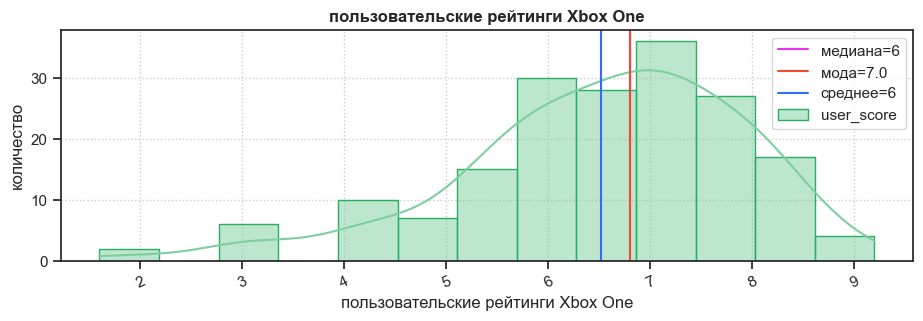

In [64]:
print('для Xbox One:')
RequestStatistics(xbox.user_score).get_hist('пользовательские рейтинги Xbox One', 
                                            mean=True, median=True, mode=True)
RequestStatistics(xbox.user_score).description()

для PlayStation:
user_score:
среднее = 6.2697, медиана = 6.80, ср.отклонение = 1.74, сумма = 971.80, min = 1.40, max = 9.30


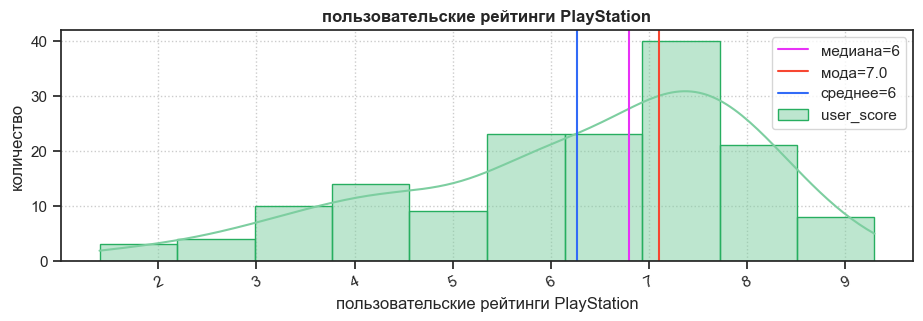

In [65]:
print('для PlayStation:')
RequestStatistics(pc.user_score).get_hist('пользовательские рейтинги PlayStation', 
                                          mean=True, median=True, mode=True)
RequestStatistics(pc.user_score).description()

In [66]:
print(f'Несмещённые дисперсии:\nдля Xbox One = {np.var(xbox.user_score, ddof=1):.4f}\n'
      f'для PlayStation = {np.var(pc.user_score, ddof=1):.4f}')

Несмещённые дисперсии:
для Xbox One = 1.9070
для PlayStation = 3.0359


Определим уровень значимости $\alpha = 0.05$, а equal_var = False (это дефолтные значения для метода get_ttest_ind())

In [67]:
RequestStatistics(xbox.user_score, pc.user_score).get_ttest_ind()

pvalue = 0.1476
принимаем H0


$\Rightarrow$ Мы не можем отвергнуть нулевую гипотезу $H_0$, с большой долей вероятности средние пользовательские рейтинги платформ ```Xbox One``` и ```PlayStation``` не имеют статистически значимых отличий

_____

Теперь проверим гпотезу, что средние пользовательские рейтинги жанров ```Action``` и ```Sports``` разные

- $H_0$: средние пользовательские рейтинги жанров Action и Sports равны
- $H_1$: средние пользовательские рейтинги жанров Action и Sports не равны

In [68]:
action = (df_new_age.loc[(df_new_age['genre'] == 'action')
                         &(~df_new_age['user_score'].isna())
                         &(df_new_age['user_score'] != -1), 'user_score'])
sport = (df_new_age.loc[(df_new_age['genre'] == 'sports')
                         &(~df_new_age['user_score'].isna())
                         &(df_new_age['user_score'] != -1), 'user_score'])

для action:
user_score:
среднее = 6.8375, медиана = 7.10, ср.отклонение = 1.33, сумма = 2659.80, min = 2.00, max = 9.10


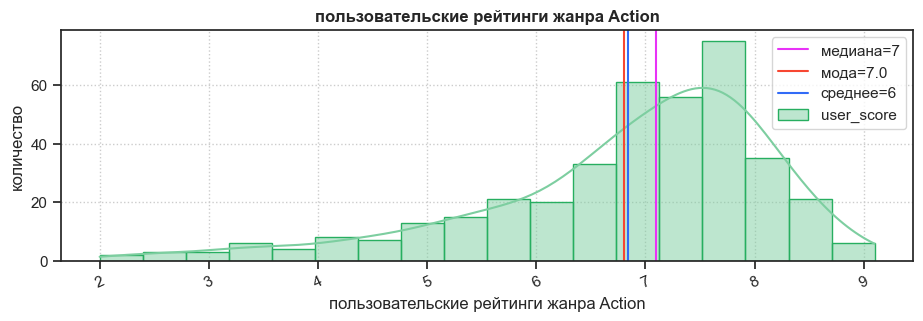

In [69]:
print('для action:')
RequestStatistics(action).get_hist('пользовательские рейтинги жанра Action', 
                                   mean=True, median=True, mode=True)
RequestStatistics(action).description()

для sport:
user_score:
среднее = 5.2381, медиана = 5.50, ср.отклонение = 1.78, сумма = 838.10, min = 0.20, max = 8.80


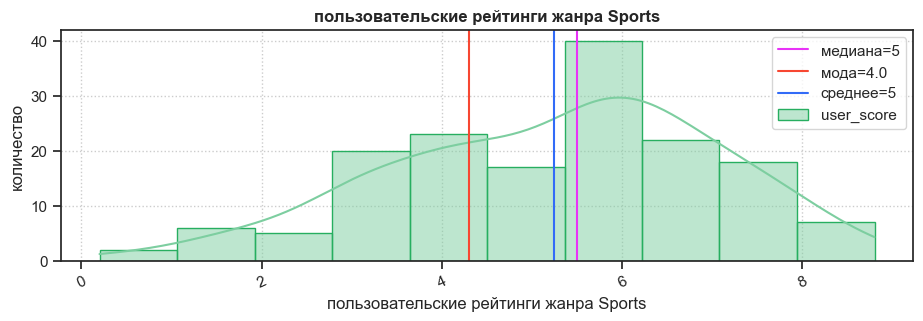

In [70]:
print('для sport:')
RequestStatistics(sport).get_hist('пользовательские рейтинги жанра Sports', 
                                  mean=True, median=True, mode=True)
RequestStatistics(sport).description()

In [71]:
print(f'Несмещённые дисперсии:\nдля action = {np.var(action, ddof=1):.4f}\n'
      f'для sport = {np.var(sport, ddof=1):.4f}')

Несмещённые дисперсии:
для action = 1.7694
для sport = 3.1806


Определим уровень значимости $\alpha = 0.05$, а equal_var = False

In [72]:
RequestStatistics(sport, action).get_ttest_ind()

pvalue = 0.0000
отвергаем H0


$\Rightarrow$ Мы не можем принять нулевую гипотезу гипотезу $H_0$, с большой долей вероятности средние пользовательские рейтинги жанров Action и Sports имеют статистически значимые отличия

**Предварительный вывод:** на данном этапе мы проверили две гипотезы и получили результаты:
- средние пользовательские рейтинги платформ Xbox One и PlayStation одинаковые
- средние пользовательские рейтинги жанров Action и Sports не равны

геймерам не всё равно, во что играть :)

_____
_____

**ОБЩИЙ ВЫВОД:**

Мы провели подробное исследование исторических данных о продаже игр, их оценок от пользователей и экспертов, жанров и разнообразных игровых платформ. Целью исследования было выявление закономерностей, определяющих успешность игры. 

В ходе исследования данных были проделаны следующие важные шаги и выявлены некоторые закономерности:
- дана общая оценка исходным данным
- отформатированы типы данных и обработаны пропуски (там, где это возможно)
- изучен выход игр по годам, что позволило определить период для дальнейшего анализа данных. Все последующие наблюдения проводились в диапазоне данных за последние 4 года
- выявлен коммерчески успешный жизненный цикл игровых платформ - среднее время "жизни" платформы 6.5 лет, но в последние годы этот срок неуклонно снижается
- определён ТОП лидеров продаж за последние 4 года - это PlayStation4, PlayStation Vita, Xbox One и Nintendo 3DS
- выявлена закономерность в том, что даже при росте продаж копий игр, денег они в последние годы приносят всё меньше, возможные причины такого тренда в:
    - в более широком применении подписной модели обслуживания клиентов и, как следствие, продаже игр и обновлений к ним в формате online. Такой подход к продажам исключает необходимоть трат на производство и распространение физических копий игр и этот факт мог отразиться на стоимости игр.
    - в переходе с игровых консолей на мобильные телефоны
    - версия же о том, что причиной снижения доходности служат набирающие популярность компактные карманные игровые приставки, не подтвердилась, так как подобные устройство в большинстве своём сконцентрированы в только в Японии
- оценено влияние отзывов на продажи игр. Отдельно рассмотрены как отзывы критиков, так и отзывы покупателей, как отзывы по всем платформам сразу, так и по наиболее популярным в отдельности. Это позволило выявить следующую закономерность:
    - продажи игр от больших платформ, таких как PlayStation и Xbox, имеют прямую корреляцию с отзывами критиков
    - а пользовательские отзывы влияют на продажи разве что китайских карманных приставок
- найден ТОП-5 самых продаваемых игр, это:
        1) экшен
        2) ролевые
        3) приключения
        4) спортивные
        5) шутеры
- найден ТОП-5 самых доходных жанров. Ими оказались:
        1) экшены
        2) шутеры
        3) спортивные
        4) ролевые
        5) misc (всё подряд)
- изучен портрет пользователей в разных частях света и выяснены вкусовые предпочтения геймеров.
- Определены наоболее популярные игровые платформы - это:
    - в **Северной Америке**:
        - Xbox - 39.9%
        - PlayStation - 39.4%
        - Nintendo - 15.3%
    - в **Европе**:
        - PlayStation - 53.3% 
        - Xbox - 24.3%
        - Nintendo - 14.5%
        - ПК - 6.4% 
    - в **Японии**:
        - Nintendo - 46.3%
        - PlayStation - 26.5%
        - карманная PlayStation Vita - 12.9%
        - карманная Wii U от Nintendo 7.5%    
    - в **других странах мира**:
        - PlayStation - 62.9% 
        - Xbox - 21%
        - Nintendo - 8.8%
        - ПК - 2.5%
- Определены ТОП-5 игровых жанров для разных частей света:
    - в **Северной Америке**:
         - экшены - 28.8%
         - шутеры - 25.2%
         - спортивные - 14.9%
         - ролевые - 10.5%
         - misc (всё подряд) - 6.2%
    - в **Европе**:
         - экшены - 30.1%
         - шутеры - 22.4%
         - спортивные - 15.6%
         - ролевые - 9.4%
         - misc (всё подряд) и гоночки делят 5-е место, у них по 5.1%
    - в **Японии**:
         - ролевые - 35.9%
         - экшены - 28.2%
         - misc (всё подряд) - 6.3%
         - драки - 5.6%
         - шутеры - 4.9%
    - в **других странах мира**:
         - экшены - 30.6%
         - шутеры - 24%
         - спортивные - 15.7%
         - ролевые - 9.1%
         - misc (всё подряд) - 5%
- Выявлено значение рейтинга от ```ESBR``` для разных частей света. Это значение неравномерно и, к примеру, для Японии имеет меньше всего влияния
- Проверены две статистические гипотезы, в результате чего определено то, что:       
    - с большой долей вероятности средние пользовательские рейтинги платформ Xbox One и PlayStation не имеют статистически значимых отличий
    - с большой долей вероятности средние пользовательские рейтинги жанров Action и Sports имеют статистически значимые отличия

_____

**Для формирования бизнес-стратегии на 2017-й год компании "Стримчик" следует обратить внимание на следующие закономерности:**


```В последние годы наблюдается общий тренд на снижение доходности игровых платформ```. С ростом количества игроков, переходом на подписную модель бизнеса, возрастающим интересом к мобильной игровой индустрии, в которую перетекают пользователи и их деньги, рынок переживает некоторый спад доходности. Нельзя сказать, что индустрия "умирает", но и всплеска продаж, как в нулевые, ожидать не приходится. В такое время стоит задуматься о развитии новых направлений бизнеса и инвестициях в другие, смежные игровому, направления. Рынок мобильных игр отличное для этого подходит.

```При разработке бизнес-стратегии на 2017-й год стоит учитывать и региональные особенности рынка```. В первую очередь это касается Японии. Япония - очень самобытная страна в мире игр, больше половины игрового рынка в ней занято всевозможными карманными приставками, только 26% занимает PlayStation, а для Xbox практически не представлена. Популярнейший жанр игр в Японии - RPG, тогда как в остальном мире это экшены и шутеры. Соответствующие маркетинговые активности должны быть сфокусированы на небольшик карманных приставках и учитывать потребности регионального покупателя.

Так же для более точной оценки предпочтений потребителей игр в Японии необходимо изучить рейтинг компании ```CERO``` - это компания как ESBR, только Японская. А японцы, как выяснилось, обращают внимание на рейтинги своих платформ и на отзывы к ним больше американцев и европейцев. 

Для остального мира картина более-менее равномерна. ```Лидером по количеству продаж игровой индустрии в мире является PlayStation, однако по доходности игры от PlayStation уступают Xbox```. Nintendo занимает устойчивую нишу в 15-20% и входит в тройку лидеров. С учётом возрастающей скорости жизни платформ стоит обращать внимание на громкие и "не очень" новинки, периодически появляющиеся на рынке.

**По игровым жанрам в мире наблюдения такие:**
- серьёзно вкладываться в ```adventure``` не стоит, но ассортимент игр этого направления нужно всегда иметь в достаточной представленности, так как их хорошо использовать как "приманку" для привлечения покупателей к своей платформе, ведь продаются они хорошо, но доход с них минимальный..
- при этом жанр ```action``` тоже не самый доходный, однако игр этого жанра продаётся больше всего, что говорит о высокой конкурентности в данном направления и, как следствие, низкой маржинальности. Для маркетинга это важный жанр, за ним нужно постоянно и внимательно следить, держать руку на пульсе. Любое отклонение в динамике продаж игр action будет сигнализировать об изменениях трендов игрового бизнеса в целом.
- ```shooter``` - самый доходный жанр, на порядок опережающий остальные. Эти игры есть смысл рекламировать, о их наличии у себя интернет-магазину "Стримчик" стоит сообщать как можно громче. 

**Что могло повлиять на исследование:**
- большое количество пропусков данных во всех видах оценок игр.
- отсутствие информации об оценках от региональных рейтинговых агентств, так как рейтинг от ESBR не покрывает все игры
- отсутствие какой-либо информации о покупателях-геймерах - кто они, какого возраста, где живут, чем интересуются помимо игр, какой мерч покупают и т.п. С коммерческой точки зрения эта информация была бы самым ценным вкладом в исследование закономерностей, определяющих успешность игр.

**Кому может быть полезно данное исследование:**

Непосредственно интернет-магазину "Стримчик", продающему по всему миру компьютерные игры. Полученная и изученная информация должна помочь интернет-магазину "Стримчик" сформировать маркетинговую и бизнес-стратегию развития интернет-магазина на предстоящий 2017-й год.